# LSTM 

In [21]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from lstm import WindowedTimeSeries, train_model, predict_one_step, predict_autoregressive

In [22]:
series = generate_data(10000, noise_level=0.05)
train_series = series[:8000, :]
val_series = series[8000:9000, :]
test_series = series[9000:, :]
train_series.shape

(8000, 3)

In [23]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10)
val_dataset = WindowedTimeSeries(val_series, seq_length=10)
test_dataset = WindowedTimeSeries(test_series, seq_length=10)

In [7]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100,
  patience=25)

Epoch [10/100], train_loss: 1.1827, val_loss: 1.2044
Epoch [20/100], train_loss: 1.1951, val_loss: 1.0818
Early stopping triggered at epoch: 29


In [8]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
X_batch, y_batch = next(iter(test_loader))

print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_batch shape: torch.Size([64, 10, 3])
y_batch shape: torch.Size([64, 3])


In [10]:
all_preds = []


for X_batch, _ in test_loader:   # Ignore targets
    preds = predict_one_step(model, X_batch)
    all_preds.append(preds)

all_preds = torch.cat(all_preds)

In [11]:
# Take first window from batch
single_window = X_batch[0]  # shape: (window_size, input_size)

steps = 20  # number of steps to predict
pred_single = predict_autoregressive(model, single_window, steps=steps)

print("Single window prediction shape:", pred_single.shape)
# Expect: (1, steps, output_size) or (steps, output_size) depending on implementation



Single window prediction shape: torch.Size([1, 3])


In [12]:
pred_single

tensor([[13.6191, 13.4028, 35.7215]])

In [13]:
steps = 10  # number of steps to predict ahead

# Make sure your model is on the same device
device = next(model.parameters()).device
X_batch = X_batch.to(device)

# Predict
pred_batch = predict_autoregressive(model, X_batch, steps=steps, device=device)

print("Batch prediction shape:", pred_batch.shape)
# Expect: (batch_size, output_size) if returning only last prediction

Batch prediction shape: torch.Size([30, 3])


In [14]:
all_preds = []
all_target = []

for X_batch, Y_batch in test_loader:   # Ignore targets
    preds = predict_autoregressive(model, X_batch, steps=10)
    all_preds.append(preds)
    all_target.append(Y_batch)

all_preds = torch.cat(all_preds)
all_target = torch.cat(all_target)
nn.MSELoss()(all_preds[10:,:], all_target[10:,:])


tensor(162.3810)

In [15]:
all_preds[10:, :].shape

torch.Size([980, 3])

In [ ]:
steps = [1,2,3,4,5,10,15,20]


for step in range(1,21):
  all_preds = []
  all_target = []
  for X_batch, Y_batch in test_loader:
    preds = predict_autoregressive(model, X_batch, steps=step)
    all_preds.append(preds)
    all_target.append(Y_batch)


  all_preds = torch.cat(all_preds)
  all_target = torch.cat(all_target)
  
  # Corrects allignment due to predicting multiple steps
  if step != 1:
    all_preds = all_preds[:-(step-1), :]
    all_target = all_target[(step-1):, :]

  mse = nn.MSELoss()(all_preds, all_target)
  print(f"{step} Steps, MSE: {mse}")


1 Steps, MSE: 1.2210992574691772
2 Steps, MSE: 1.5966100692749023
3 Steps, MSE: 2.0838980674743652
4 Steps, MSE: 2.793516159057617
5 Steps, MSE: 3.976187229156494
6 Steps, MSE: 6.1767449378967285
7 Steps, MSE: 10.43215274810791
8 Steps, MSE: 18.102367401123047
9 Steps, MSE: 30.12921714782715
10 Steps, MSE: 45.819976806640625
11 Steps, MSE: 59.99571228027344
12 Steps, MSE: 67.9517593383789
13 Steps, MSE: 71.01656341552734
14 Steps, MSE: 73.193115234375
15 Steps, MSE: 74.682373046875
16 Steps, MSE: 75.25230407714844
17 Steps, MSE: 74.755859375
18 Steps, MSE: 74.91560363769531
19 Steps, MSE: 75.64617919921875
20 Steps, MSE: 77.72937774658203


## LSTM Using Direct Predictions

In [17]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=20)
val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=20)

In [18]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100)

Epoch [10/100], train_loss: 24.8337, val_loss: 28.5764
Epoch [20/100], train_loss: 18.9113, val_loss: 23.0522
Early stopping triggered at epoch: 25


In [19]:
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_target = []

for X_batch, Y_batch in test_loader:   # Ignore targets
    preds = predict_autoregressive(model, X_batch, steps=1)
    all_preds.append(preds)
    all_target.append(Y_batch)

all_preds = torch.cat(all_preds)
all_target = torch.cat(all_target)
nn.MSELoss()(all_preds[10:,:], all_target[10:,:])

tensor(24.6809)

In [26]:
# steps = [1,5,10,15,20]
steps = np.arange(1,21)
MSE = np.zeros((len(steps)))

for i, step in enumerate(steps):
  train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=step)
  val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=step) 

  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100,
  patience=10,
  silence=True)

  test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
  
  all_preds = []
  all_target = []
  for X_batch, Y_batch in test_loader:
    preds = predict_autoregressive(model, X_batch)
    all_preds.append(preds)
    all_target.append(Y_batch)


  all_preds = torch.cat(all_preds)
  all_target = torch.cat(all_target)
  

  mse = nn.MSELoss()(all_preds, all_target)
  MSE[i] = mse
  print(f"{step} Steps, MSE: {mse}")

1 Steps, MSE: 0.9091660380363464
2 Steps, MSE: 1.0844312906265259
3 Steps, MSE: 1.1906139850616455
4 Steps, MSE: 1.4112507104873657
5 Steps, MSE: 2.157116651535034
6 Steps, MSE: 2.755082130432129
7 Steps, MSE: 3.563005208969116
8 Steps, MSE: 5.141486167907715
9 Steps, MSE: 10.18492603302002
10 Steps, MSE: 16.391876220703125
11 Steps, MSE: 15.803345680236816
12 Steps, MSE: 16.38728904724121
13 Steps, MSE: 18.459938049316406
14 Steps, MSE: 17.55135726928711
15 Steps, MSE: 18.05364990234375
16 Steps, MSE: 17.578876495361328
17 Steps, MSE: 16.161638259887695
18 Steps, MSE: 28.00893211364746
19 Steps, MSE: 22.684354782104492
20 Steps, MSE: 31.548778533935547


In [27]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k"], MSE),
  ),
  coords=dict(
    k=steps,
  ),
  attrs=dict(
    time_step=0.05,
    description="MSE of LSTM",
  )
)

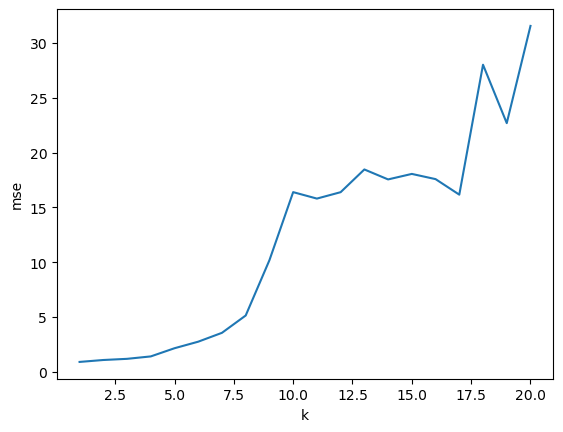

In [28]:
ds.mse.plot(x="k")


In [30]:
out_path = Path("../data/processed/mse_LSTM.nc")

ds.to_netcdf(out_path)